In [24]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt
import skimage.filters
from skimage.util import random_noise 
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral


IMG_WIDTH = 352
IMG_HEIGHT = 352
IMG_CHANNELS = 3

# s-a ales din setul de date de 468 img 75% pt antrenare si 25% pentru testare

TRAIN_PATH = 'archive/segmentation/train/'
TEST_PATH = 'archive/segmentation/test/'

seed = 42
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)


In [26]:

# print('Resizing training images and masks')

correspondent = {}

#train images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = crop(img, ((10, 50),(25, 25), (0, 0)), copy=False)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img
    correspondent[n] = str(id_)

# #train masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = crop(mask_, ((10, 50),(25, 25)), copy=False)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask_

# # test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

size_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = crop(mask_, ((10, 50),(25, 25)), copy=False)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask_
print('Done!')

100%|█████████████████████████████████████████████| 720/720 [00:21<00:00, 33.42it/s]


Resizing test images


100%|█████████████████████████████████████████████| 216/216 [00:06<00:00, 32.69it/s]

Done!


332


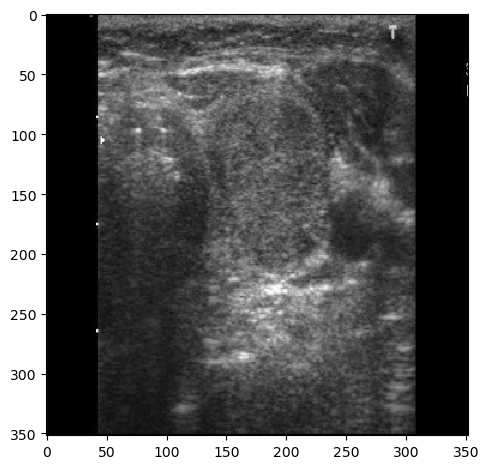

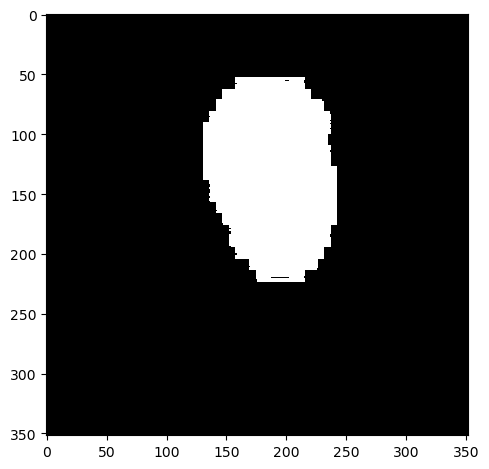

In [27]:
 image_x = random.randint(0, len(train_ids)-1)
#image_x = 240
print(image_x)
# print(correspondent[image_x])
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [7]:
#build the U-Net model.
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

# the input has to be changed from 8-bit to a floating point.
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Contraction path

# kernel_initializor defines the initial values, he_normal is a truncated normal
# distribution, other exemple Orthogonal, identity normal (gaussian distribution).

c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# dropout 10% form c1.
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D(2,2)(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 352, 352, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 352, 352, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 352, 352, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 352, 352, 16)         0         ['conv2d[0][0]']              
                                                                                              

 conv2d_15 (Conv2D)          (None, 176, 176, 32)         9248      ['dropout_7[0][0]']           
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 352, 352, 16)         2064      ['conv2d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 352, 352, 32)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 352, 352, 16)         4624      ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8

In [28]:
# Se antreneaza modelul
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_augmented11_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpoiter

]
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=25, callbacks=callbacks)


Epoch 1/25
81/81 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9129
Epoch 1: val_loss improved from inf to 0.22472, saving model to model_augmented11_for_nuclei.h5
81/81 [==============================] - 145s 2s/step - loss: 0.2001 - accuracy: 0.9129 - val_loss: 0.2247 - val_accuracy: 0.9048
Epoch 2/25
81/81 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9225
Epoch 2: val_loss did not improve from 0.22472
81/81 [==============================] - 158s 2s/step - loss: 0.1802 - accuracy: 0.9225 - val_loss: 0.2252 - val_accuracy: 0.9067
Epoch 3/25
81/81 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9271
Epoch 3: val_loss did not improve from 0.22472
81/81 [==============================] - 164s 2s/step - loss: 0.1687 - accuracy: 0.9271 - val_loss: 0.2389 - val_accuracy: 0.8958


In [ ]:
# Se incarca modelul antrenat anterior
# model = tf.keras.models.load_model('model2_for_nuclei.h5')

In [29]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



7/7 [==============================] - 11s 2s/step


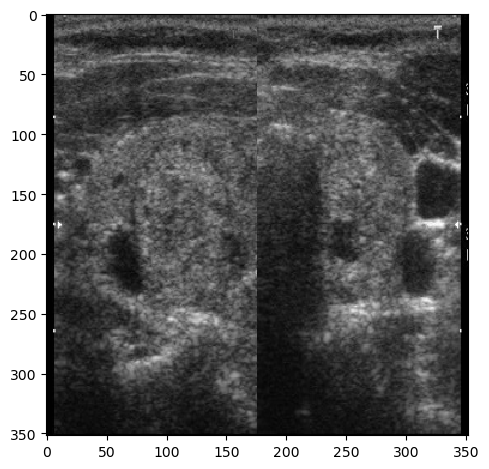

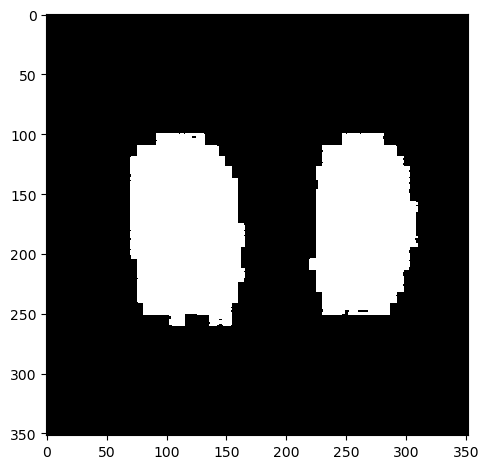

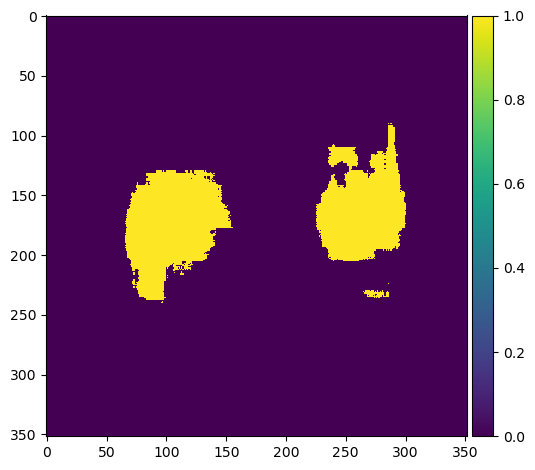

In [30]:
# Performe a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


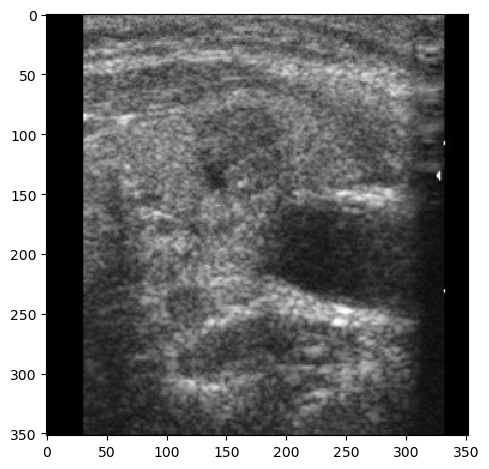

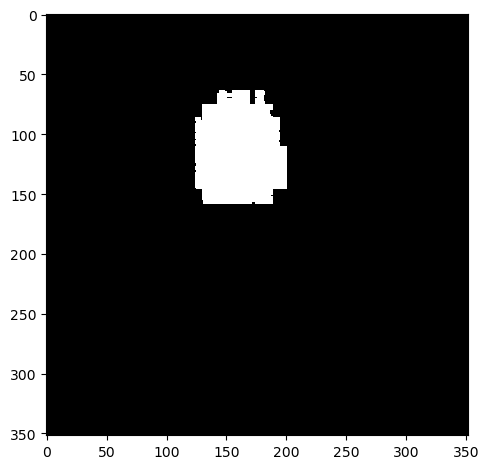

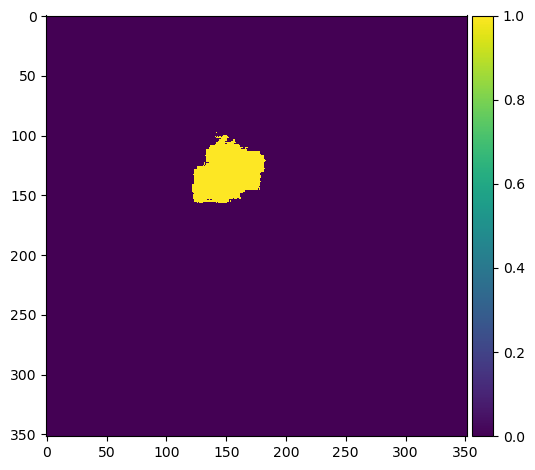

71
42
2297
12909
108656
MCC:  -0.0392493766993805
F1:  0.005493786788750818
Acc:  0.8772759555785123
IoU:  0.0027544596012591817


In [31]:
 # Se evalueaza sistemul 
    
# Se alege un numar aleator    
ix = random.randint(0, len(preds_val_t))

# Se afiseaza imaginea impreuna cu masca si predictia
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

print("Image number: ",ix)
gtMask = Y_train[ix]
predMask = preds_val_t[ix]   

# Get the parameters value 
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(gtMask)):
    for j in range(len(gtMask[i])):
        if gtMask[i][j] == True and predMask[i][j] == 1:
            tp += 1
        elif gtMask[i][j] == False and predMask[i][j] == 1:
            fp += 1
        elif gtMask[i][j] == True and predMask[i][j] == 0:
            fn += 1
        elif gtMask[i][j] == False and predMask[i][j] == 0:
            tn += 1

# Print parameters
print("True positive: ",tp)
print("False positive: ",fp)
print("False negative: ",fn)
print("True negative: ",tn)

# Calculate the evaluation metrics
iou = tp / (tp + fp + fn)
total = tp + fp + fn + tn
accuracy = (tp + tn) / total
f1_score = (2 * tp) / ((2 * tp) + fp + fn)
mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

# Print the evaluation metrics
print("MCC: ", mcc)
print("F1: ", f1_score)
print("Acc: ", accuracy)    
print("IoU: ", iou)


In [1]:
import sys
import numpy

# se verifica cum arata matricea imaginii
# numpy.set_printoptions(threshold=sys.maxsize)
# p = 0
# for i in range(len(predMask)):
#     for j in range(len(predMask[i])):
#         print(predMask[i][j], end=' ')
#     print()

In [33]:
# Se incearca o matrice de coincidenta

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

# predMask = predMask.astype(np.int)
# gtMask = predMask.astype(np.int)
# for i in range(len(predMask)):
#     for j in range(len(predMask[i])):
#         print(predMask[i][j], end=' ')
#     print()
# actual = gtMask
# predicted = predMask

# confusion_matrix = metrics.confusion_matrix(actual, predicted)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# cm_display.plot()
# plt.show()